# 1,2

## Libs and modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms

## Loading Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
testset_size = len(testset)
dataset_size = len(dataset)
print('dataset size=%i\n'%dataset_size,'test set size=%i'%testset_size)

dataset size=50000
 test set size=10000


In [ ]:
#Set the batch size here
batch_size=50
#set the validation set size and defining data loaders
val_size = 5000
train_size = len(dataset) - val_size
trainset, valid_set = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

In [ ]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Exploratory Data Analysis

In [ ]:
# defining a function to show a random batch of images from a dataset with thier labels (just showing 80 images at most cause we just want to see the dataset)
def sample_show(setloader,batch_size):
  dataiter = iter(setloader)
  images, labels = dataiter.next()
  print(images.shape, labels.shape)
  # show images in a batch
  if batch_size <= 80:
    fig = plt.figure(figsize=(20,np.ceil(batch_size/16)*1.5)) 
    for idx in np.arange(batch_size):
      ax = fig.add_subplot(np.ceil(batch_size/16), 16, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx]/2+0.5, (1, 2, 0)))
      ax.set_title(classes[labels[idx]])
  else:
    fig = plt.figure(figsize=(20,np.ceil(80/16)*1.5)) 
    for idx in np.arange(80):
      ax = fig.add_subplot(np.ceil(80/16), 16, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx]/2+0.5, (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

torch.Size([50, 3, 32, 32]) torch.Size([50])


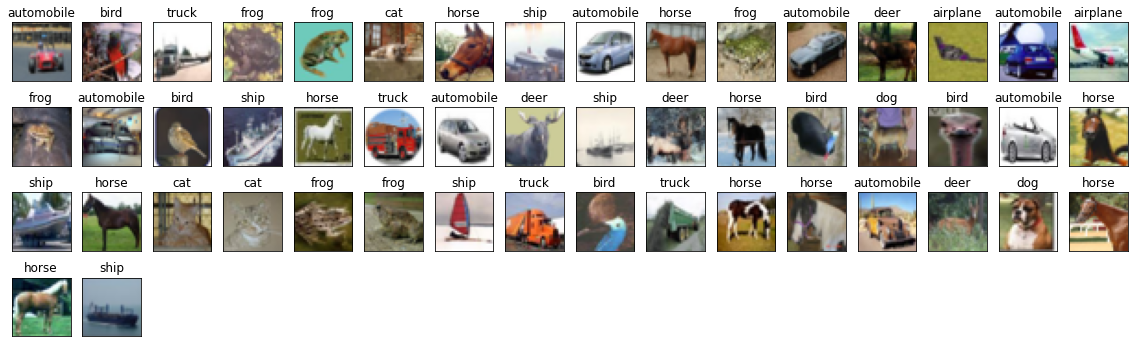

In [ ]:
sample_show(trainloader,batch_size)

## Network Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.relu(self.conv11(x))
        x = self.pool(self.relu(self.conv12(x)))
        x = self.relu(self.conv21(x))
        x = self.pool(self.relu(self.conv22(x)))
        x = self.relu(self.conv31(x))
        x = self.pool(self.relu(self.conv32(x)))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Optimizer & Loss Function

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

## Training The Model

In [ ]:
epochs = 20

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizer.zero_grad()
    # forward pass
    output = net(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizer.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = net(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))

  print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
        "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 
  if valid_loss <= valid_loss_min:
    print("Validation loss decreased")
    torch.save(net.state_dict(), "Best_Model")
    valid_loss_min = valid_loss

Validation accuracy: 0.487	 Train accuracy: 0.375 Epoch: 1/20 	 Training loss: 83.718 	 Validation loss: 69.453
Validation loss decreased
Validation accuracy: 0.590	 Train accuracy: 0.564 Epoch: 2/20 	 Training loss: 60.536 	 Validation loss: 58.193
Validation loss decreased
Validation accuracy: 0.627	 Train accuracy: 0.636 Epoch: 3/20 	 Training loss: 51.099 	 Validation loss: 53.805
Validation loss decreased
Validation accuracy: 0.656	 Train accuracy: 0.675 Epoch: 4/20 	 Training loss: 45.986 	 Validation loss: 49.348
Validation loss decreased
Validation accuracy: 0.663	 Train accuracy: 0.702 Epoch: 5/20 	 Training loss: 42.334 	 Validation loss: 50.445
Validation accuracy: 0.644	 Train accuracy: 0.724 Epoch: 6/20 	 Training loss: 39.254 	 Validation loss: 52.143
Validation accuracy: 0.684	 Train accuracy: 0.741 Epoch: 7/20 	 Training loss: 36.869 	 Validation loss: 47.437
Validation loss decreased
Validation accuracy: 0.684	 Train accuracy: 0.753 Epoch: 8/20 	 Training loss: 34.873 

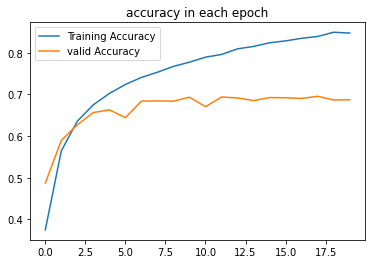

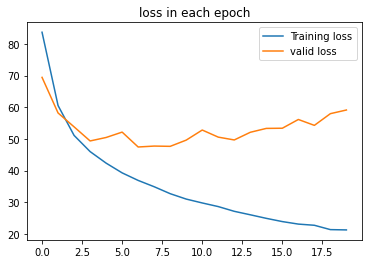

In [ ]:
plt.plot(train_accuracys, label="Training Accuracy")
plt.plot(valid_accuracys, label="valid Accuracy")
plt.title('accuracy in each epoch')
plt.legend()
plt.show()
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="valid loss")
plt.title('loss in each epoch')
plt.legend()
plt.show()

## Testing the Model

In [ ]:
state_dict = torch.load('/content/Best_Model')
net.load_state_dict(state_dict)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%   (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i], class_correct[i], class_total[i]))
print('\n Overal Test Accuracy: %2d%% (%2d/%2d)' % (
      100.*np.sum(class_correct)/np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)
      ))

Accuracy of airplane : 70 %   (707/1000)
Accuracy of automobile : 83 %   (835/1000)
Accuracy of  bird : 48 %   (489/1000)
Accuracy of   cat : 38 %   (387/1000)
Accuracy of  deer : 72 %   (725/1000)
Accuracy of   dog : 69 %   (691/1000)
Accuracy of  frog : 74 %   (743/1000)
Accuracy of horse : 74 %   (747/1000)
Accuracy of  ship : 77 %   (778/1000)
Accuracy of truck : 83 %   (832/1000)

 Overal Test Accuracy: 69% (6934/10000)


# 3: 0, 1 and 2 hidden layers

## Libs and modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms

## Loading Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Set the batch size here
batch_size=50
#set the validation set size and defining data loaders
val_size = 5000
train_size = len(dataset) - val_size
trainset, valid_set = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
classes = dataset.classes

## Network Architecture

### 0 layer

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(3*32*32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 32*32*3)             #Flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net0 = Net0()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer0 = optim.Adam(net0.parameters(), lr=0.002)

### 1 layer

In [ ]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv11 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(32*16*16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.relu(self.conv11(x))
        x = self.pool(self.relu(self.conv12(x)))
        
        x = x.view(-1, 32*16*16)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net1 = Net1()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(net1.parameters(), lr=0.002)

### 2 layers

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(32*8*8, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.relu(self.conv11(x))
        x = self.pool(self.relu(self.conv12(x)))
        x = self.relu(self.conv21(x))
        x = self.pool(self.relu(self.conv22(x)))
        
        x = x.view(-1, 32*8*8)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net2 = Net2()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(net2.parameters(), lr=0.002)

## Training The Model

### 0 layer

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizer0.zero_grad()
    # forward pass
    output = net0(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizer0.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = net0(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%5==0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
          "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 
train_acc0=train_accuracys
valid_acc0=valid_accuracys

Validation accuracy: 0.460	 Train accuracy: 0.526 Epoch: 5/10 	 Training loss: 67.866 	 Validation loss: 76.963
Validation accuracy: 0.488	 Train accuracy: 0.619 Epoch: 10/10 	 Training loss: 54.991 	 Validation loss: 81.923


### 1 layer

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizer1.zero_grad()
    # forward pass
    output = net1(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizer1.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = net1(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%5==0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
          "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 
train_acc1=train_accuracys
valid_acc1=valid_accuracys

Validation accuracy: 0.659	 Train accuracy: 0.895 Epoch: 5/10 	 Training loss: 14.937 	 Validation loss: 67.172
Validation accuracy: 0.638	 Train accuracy: 0.971 Epoch: 10/10 	 Training loss: 4.556 	 Validation loss: 119.732


### 2 layer

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizer2.zero_grad()
    # forward pass
    output = net2(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizer2.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = net2(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%5==0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
          "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 
train_acc2=train_accuracys
valid_acc2=valid_accuracys

Validation accuracy: 0.676	 Train accuracy: 0.743 Epoch: 5/10 	 Training loss: 36.292 	 Validation loss: 47.043
Validation accuracy: 0.666	 Train accuracy: 0.869 Epoch: 10/10 	 Training loss: 18.321 	 Validation loss: 64.969


### accuracy plots

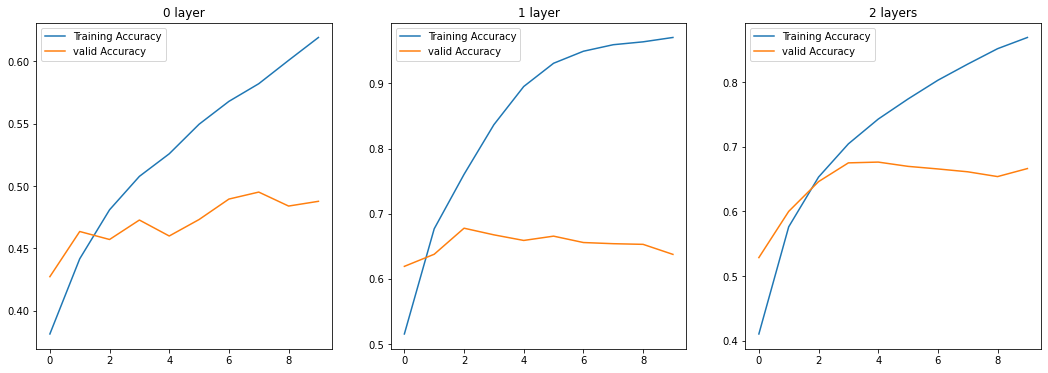

In [ ]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 3, 1)
ax.plot(train_acc0, label="Training Accuracy")
ax.plot(valid_acc0, label="valid Accuracy")
ax.set_title("0 layer")
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.plot(train_acc1, label="Training Accuracy")
ax.plot(valid_acc1, label="valid Accuracy")
ax.set_title("1 layer")
ax.legend()

ax = fig.add_subplot(1, 3, 3)
ax.plot(train_acc2, label="Training Accuracy")
ax.plot(valid_acc2, label="valid Accuracy")
ax.set_title("2 layers")
ax.legend()

# 4: Relu vs Sigmoid vs Tanh

## Libs and modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms

## Loading Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
testset_size = len(testset)
dataset_size = len(dataset)
print('dataset size=%i\n'%dataset_size,'test set size=%i'%testset_size)

dataset size=50000
 test set size=10000


In [ ]:
#Set the batch size here
batch_size=50
#set the validation set size and defining data loaders
val_size = 5000
train_size = len(dataset) - val_size
trainset, valid_set = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
classes = dataset.classes

## Network Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Netrelu(nn.Module):
    def __init__(self):
        super(Netrelu, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.relu(self.conv11(x))
        x = self.pool(self.relu(self.conv12(x)))
        x = self.relu(self.conv21(x))
        x = self.pool(self.relu(self.conv22(x)))
        x = self.relu(self.conv31(x))
        x = self.pool(self.relu(self.conv32(x)))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


netrelu = Netrelu()

In [ ]:
class Netsigmoid(nn.Module):
    def __init__(self):
        super(Netsigmoid, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.sigmoid=nn.Sigmoid()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.sigmoid(self.conv11(x))
        x = self.pool(self.sigmoid(self.conv12(x)))
        x = self.sigmoid(self.conv21(x))
        x = self.pool(self.sigmoid(self.conv22(x)))
        x = self.sigmoid(self.conv31(x))
        x = self.pool(self.sigmoid(self.conv32(x)))
        
        x = x.view(-1, 64*4*4)             #Flattening
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


netsigmoid = Netsigmoid()

In [ ]:
class Nettanh(nn.Module):
    def __init__(self):
        super(Nettanh, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.tanh=nn.Tanh()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.tanh(self.conv11(x))
        x = self.pool(self.tanh(self.conv12(x)))
        x = self.tanh(self.conv21(x))
        x = self.pool(self.tanh(self.conv22(x)))
        x = self.tanh(self.conv31(x))
        x = self.pool(self.tanh(self.conv32(x)))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


nettanh = Nettanh()

## Optimizer & Loss Function

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizerrelu = optim.Adam(netrelu.parameters(), lr=0.002)
optimizersigmoid = optim.Adam(netsigmoid.parameters(), lr=0.002)
optimizertanh = optim.Adam(nettanh.parameters(), lr=0.002)

## Training The Model

### relu

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizerrelu.zero_grad()
    # forward pass
    output = netrelu(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizerrelu.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = netrelu(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%3 == 0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
        "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 

relu_train_acc=train_accuracys
relu_val_acc=valid_accuracys

Validation accuracy: 0.627	 Train accuracy: 0.613 Epoch: 3/10 	 Training loss: 54.438 	 Validation loss: 53.665
Validation accuracy: 0.682	 Train accuracy: 0.713 Epoch: 6/10 	 Training loss: 40.446 	 Validation loss: 47.658
Validation accuracy: 0.689	 Train accuracy: 0.771 Epoch: 9/10 	 Training loss: 32.428 	 Validation loss: 48.676


### sigmoid

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizersigmoid.zero_grad()
    # forward pass
    output = netsigmoid(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizersigmoid.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = netsigmoid(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%3 == 0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
        "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 

sigmoid_train_acc=train_accuracys
sigmoid_val_acc=valid_accuracys

Validation accuracy: 0.099	 Train accuracy: 0.099 Epoch: 3/10 	 Training loss: 115.143 	 Validation loss: 115.137
Validation accuracy: 0.102	 Train accuracy: 0.100 Epoch: 6/10 	 Training loss: 115.141 	 Validation loss: 115.134
Validation accuracy: 0.099	 Train accuracy: 0.098 Epoch: 9/10 	 Training loss: 115.142 	 Validation loss: 115.146


### tanh

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizertanh.zero_grad()
    # forward pass
    output = nettanh(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizertanh.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = nettanh(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%3 == 0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
        "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 

tanh_train_acc=train_accuracys
tanh_val_acc=valid_accuracys

Validation accuracy: 0.646	 Train accuracy: 0.656 Epoch: 3/10 	 Training loss: 48.847 	 Validation loss: 49.868
Validation accuracy: 0.679	 Train accuracy: 0.701 Epoch: 6/10 	 Training loss: 42.985 	 Validation loss: 45.393
Validation accuracy: 0.676	 Train accuracy: 0.706 Epoch: 9/10 	 Training loss: 41.809 	 Validation loss: 47.372


### plot accuracy

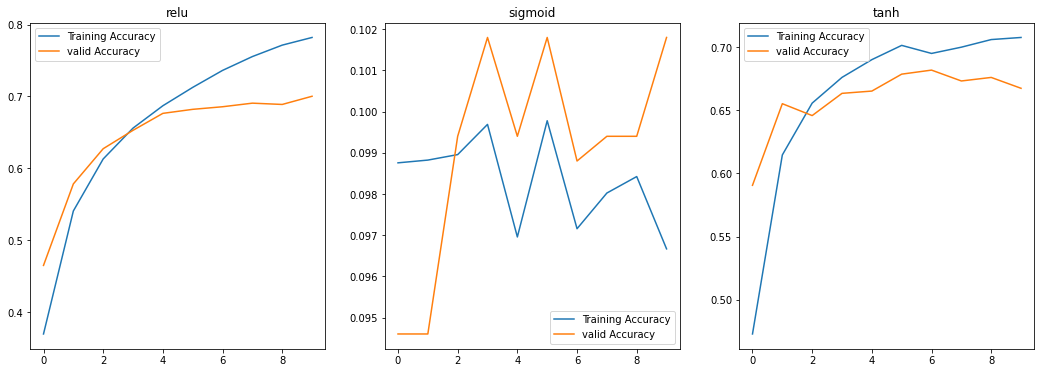

In [ ]:
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1, 3, 1)
ax.plot(relu_train_acc, label="Training Accuracy")
ax.plot(relu_val_acc, label="valid Accuracy")
ax.set_title("relu")
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.plot(sigmoid_train_acc, label="Training Accuracy")
ax.plot(sigmoid_val_acc, label="valid Accuracy")
ax.set_title("sigmoid")
ax.legend()

ax = fig.add_subplot(1, 3, 3)
ax.plot(tanh_train_acc, label="Training Accuracy")
ax.plot(tanh_val_acc, label="valid Accuracy")
ax.set_title("tanh")
ax.legend()
plt.show()

# 5: Adam vs Gradient descent

## Libs and modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms

## Loading Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
testset_size = len(testset)
dataset_size = len(dataset)
print('dataset size=%i\n'%dataset_size,'test set size=%i'%testset_size)

dataset size=50000
 test set size=10000


In [ ]:
#Set the batch size here
batch_size=50
#set the validation set size and defining data loaders
val_size = 5000
train_size = len(dataset) - val_size
trainset, valid_set = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
classes = dataset.classes

## Network Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Netadam(nn.Module):
    def __init__(self):
        super(Netadam, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.relu(self.conv11(x))
        x = self.pool(self.relu(self.conv12(x)))
        x = self.relu(self.conv21(x))
        x = self.pool(self.relu(self.conv22(x)))
        x = self.relu(self.conv31(x))
        x = self.pool(self.relu(self.conv32(x)))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


netadam = Netadam()

In [ ]:
class Netsgd(nn.Module):
    def __init__(self):
        super(Netsgd, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.relu(self.conv11(x))
        x = self.pool(self.relu(self.conv12(x)))
        x = self.relu(self.conv21(x))
        x = self.pool(self.relu(self.conv22(x)))
        x = self.relu(self.conv31(x))
        x = self.pool(self.relu(self.conv32(x)))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


netsgd = Netsgd()

## Optimizer & Loss Function

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizeradam = optim.Adam(netadam.parameters(), lr=0.002)
optimizersgd = optim.SGD(netsgd.parameters(), lr=0.002, momentum = 0.9)

## Training The Model

### Adam

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizeradam.zero_grad()
    # forward pass
    output = netadam(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizeradam.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = netadam(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%3 == 0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
        "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 

Adam_train_acc=train_accuracys
Adam_val_acc=valid_accuracys

Validation accuracy: 0.609	 Train accuracy: 0.603 Epoch: 3/10 	 Training loss: 55.115 	 Validation loss: 54.644
Validation accuracy: 0.681	 Train accuracy: 0.712 Epoch: 6/10 	 Training loss: 40.838 	 Validation loss: 45.670
Validation accuracy: 0.687	 Train accuracy: 0.761 Epoch: 9/10 	 Training loss: 33.854 	 Validation loss: 46.550


### SGD

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizersgd.zero_grad()
    # forward pass
    output = netsgd(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizersgd.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = netsgd(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%3 == 0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
        "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 

SGD_train_acc=train_accuracys
SGD_val_acc=valid_accuracys

Validation accuracy: 0.095	 Train accuracy: 0.103 Epoch: 3/10 	 Training loss: 115.120 	 Validation loss: 115.112
Validation accuracy: 0.334	 Train accuracy: 0.296 Epoch: 6/10 	 Training loss: 94.242 	 Validation loss: 91.034
Validation accuracy: 0.450	 Train accuracy: 0.454 Epoch: 9/10 	 Training loss: 74.884 	 Validation loss: 75.064


### accuracy plots

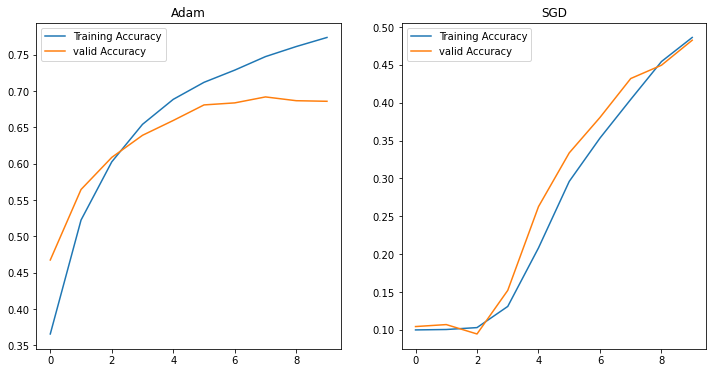

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(Adam_train_acc, label="Training Accuracy")
ax.plot(Adam_val_acc, label="valid Accuracy")
ax.set_title("Adam")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(SGD_train_acc, label="Training Accuracy")
ax.plot(SGD_val_acc, label="valid Accuracy")
ax.set_title("SGD")
ax.legend()

# 6: reducing training data to 600 data in each class

## Libs and modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms

## Loading Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Set the batch size here
batch_size=50

In [ ]:
targets = np.array(dataset.targets)
class_counts = 10
classes = dataset.classes
nb_classes = len(classes)

# Create artificial imbalanced class counts
imbal_class_counts = [600] * 10

# Get class indices
class_indices = [np.where(targets == i)[0] for i in range(nb_classes)]

# Get imbalanced number of instances
imbal_class_indices = [class_idx[:class_count] for class_idx, class_count in zip(class_indices, imbal_class_counts)]
imbal_class_indices = np.hstack(imbal_class_indices)

# Set target and data to dataset
dataset.targets = targets[imbal_class_indices]
dataset.data = dataset.data[imbal_class_indices]

assert len(dataset.targets) == len(dataset.data)

In [ ]:
class_count = {}
for _, prediction in dataset:
    label = classes[prediction]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'airplane': 600,
 'automobile': 600,
 'bird': 600,
 'cat': 600,
 'deer': 600,
 'dog': 600,
 'frog': 600,
 'horse': 600,
 'ship': 600,
 'truck': 600}

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
classes = dataset.classes

## Network Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class Netreduced(nn.Module):
    def __init__(self):
        super(Netreduced, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=8
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.relu(self.conv11(x))
        x = self.pool(self.relu(self.conv12(x)))
        x = self.relu(self.conv21(x))
        x = self.pool(self.relu(self.conv22(x)))
        x = self.relu(self.conv31(x))
        x = self.pool(self.relu(self.conv32(x)))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


netreduced = Netreduced()

## Optimizer & Loss Function

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizerreduced = optim.Adam(netreduced.parameters(), lr=0.002)

## Training The Model

### reduced training set

In [ ]:
epochs = 20

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizerreduced.zero_grad()
    # forward pass
    output = netreduced(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizerreduced.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in testloader:
    # forward pass
    output = netreduced(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(testloader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(testloader))
  if epoch%5 == 0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(testloader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
        "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 

reduced_train_acc=train_accuracys
reduced_val_acc=valid_accuracys

Validation accuracy: 0.406	 Train accuracy: 0.407 Epoch: 5/20 	 Training loss: 80.613 	 Validation loss: 81.817
Validation accuracy: 0.455	 Train accuracy: 0.546 Epoch: 10/20 	 Training loss: 61.901 	 Validation loss: 77.576
Validation accuracy: 0.461	 Train accuracy: 0.708 Epoch: 15/20 	 Training loss: 39.561 	 Validation loss: 91.877
Validation accuracy: 0.448	 Train accuracy: 0.856 Epoch: 20/20 	 Training loss: 20.055 	 Validation loss: 138.159


### accuracy plots

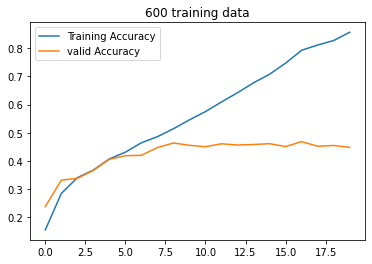

In [ ]:
fig = plt.figure(figsize=(6,4))
plt.plot(reduced_train_acc, label="Training Accuracy")
plt.plot(reduced_val_acc, label="valid Accuracy")
plt.title("600 training data")
plt.legend()

# 7: less convolutional layer in each hidden layer but using bigger kernel

## Libs and modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms

## Loading Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
testset_size = len(testset)
dataset_size = len(dataset)
print('dataset size=%i\n'%dataset_size,'test set size=%i'%testset_size)

dataset size=50000
 test set size=10000


In [ ]:
#Set the batch size here
batch_size=50
#set the validation set size and defining data loaders
val_size = 5000
train_size = len(dataset) - val_size
trainset, valid_set = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

In [ ]:
classes = dataset.classes

## Network Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Netker(nn.Module):
    def __init__(self):
        super(Netker, self).__init__()
        self.conv11 = nn.Conv2d(3, 16, kernel_size=5, padding=2)  #input_channel=3 , output_channel=16  
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=7, stride=1, padding=2)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=6, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*2*2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):

        x = self.pool(self.relu(self.conv11(x)))
        x = self.pool(self.relu(self.conv21(x)))
        x = self.pool(self.relu(self.conv31(x)))
        
        x = x.view(-1, 64*2*2)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


netker = Netker()

## Optimizer & Loss Function

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizerker = optim.Adam(netker.parameters(), lr=0.002)

## Training The Model

In [ ]:
epochs = 20

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizerker.zero_grad()
    # forward pass
    output = netker(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizerker.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = netker(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))

  print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
        "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 

Validation accuracy: 0.540	 Train accuracy: 0.433 Epoch: 1/20 	 Training loss: 76.780 	 Validation loss: 63.396
Validation accuracy: 0.612	 Train accuracy: 0.590 Epoch: 2/20 	 Training loss: 57.574 	 Validation loss: 53.875
Validation accuracy: 0.640	 Train accuracy: 0.653 Epoch: 3/20 	 Training loss: 49.378 	 Validation loss: 50.940
Validation accuracy: 0.670	 Train accuracy: 0.689 Epoch: 4/20 	 Training loss: 44.180 	 Validation loss: 47.150
Validation accuracy: 0.669	 Train accuracy: 0.716 Epoch: 5/20 	 Training loss: 40.501 	 Validation loss: 48.707
Validation accuracy: 0.688	 Train accuracy: 0.737 Epoch: 6/20 	 Training loss: 37.269 	 Validation loss: 47.699
Validation accuracy: 0.665	 Train accuracy: 0.758 Epoch: 7/20 	 Training loss: 34.752 	 Validation loss: 52.137
Validation accuracy: 0.687	 Train accuracy: 0.768 Epoch: 8/20 	 Training loss: 33.012 	 Validation loss: 46.745
Validation accuracy: 0.684	 Train accuracy: 0.785 Epoch: 9/20 	 Training loss: 30.618 	 Validation loss:

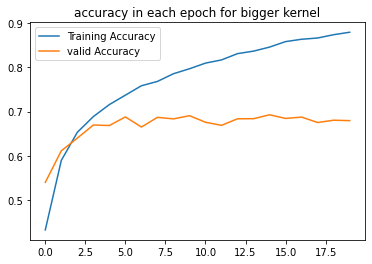

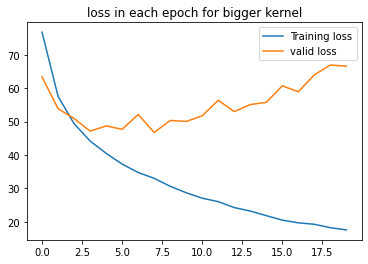

In [ ]:
plt.plot(train_accuracys, label="Training Accuracy")
plt.plot(valid_accuracys, label="valid Accuracy")
plt.title('accuracy in each epoch for bigger kernel')
plt.legend()
plt.show()
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="valid loss")
plt.title('loss in each epoch for bigger kernel')
plt.legend()
plt.show()

# 8: Dropout

## Libs and modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms

## Loading Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Set the batch size here
batch_size=50
#set the validation set size and defining data loaders
val_size = 5000
train_size = len(dataset) - val_size
trainset, valid_set = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
classes = dataset.classes

## Network Architecture

### dropout = 10%

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Netdo10(nn.Module):
    def __init__(self):
        super(Netdo10, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout=nn.Dropout(p=0.1)
    def forward(self, x):

        x = self.dropout(self.relu(self.conv11(x)))
        x = self.pool(self.dropout(self.relu(self.conv12(x))))
        x = self.dropout(self.relu(self.conv21(x)))
        x = self.pool(self.dropout(self.relu(self.conv22(x))))
        x = self.dropout(self.relu(self.conv31(x)))
        x = self.pool(self.dropout(self.relu(self.conv32(x))))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


netdo10 = Netdo10()

### Dropout = 20%

In [ ]:
class Netdo20(nn.Module):
    def __init__(self):
        super(Netdo20, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout=nn.Dropout(p=0.2)
    def forward(self, x):

        x = self.dropout(self.relu(self.conv11(x)))
        x = self.pool(self.dropout(self.relu(self.conv12(x))))
        x = self.dropout(self.relu(self.conv21(x)))
        x = self.pool(self.dropout(self.relu(self.conv22(x))))
        x = self.dropout(self.relu(self.conv31(x)))
        x = self.pool(self.dropout(self.relu(self.conv32(x))))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


netdo20 = Netdo20()

### Dropout = 30%

In [ ]:
class Netdo30(nn.Module):
    def __init__(self):
        super(Netdo30, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout=nn.Dropout(p=0.3)
    def forward(self, x):

        x = self.dropout(self.relu(self.conv11(x)))
        x = self.pool(self.dropout(self.relu(self.conv12(x))))
        x = self.dropout(self.relu(self.conv21(x)))
        x = self.pool(self.dropout(self.relu(self.conv22(x))))
        x = self.dropout(self.relu(self.conv31(x)))
        x = self.pool(self.dropout(self.relu(self.conv32(x))))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


netdo30 = Netdo30()

## Optimizer & Loss Function

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizerdo10 = optim.Adam(netdo10.parameters(), lr=0.002)
optimizerdo20 = optim.Adam(netdo20.parameters(), lr=0.002)
optimizerdo30 = optim.Adam(netdo30.parameters(), lr=0.002)

## Training The Model

### 10%

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizerdo10.zero_grad()
    # forward pass
    output = netdo10(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizerdo10.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = netdo10(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%5 == 0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
          "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 
train_accdo10 = train_accuracys
val_accdo10 = valid_accuracys
train_lossdo10 = train_losses
val_lossdo10 = valid_losses

Validation accuracy: 0.638	 Train accuracy: 0.640 Epoch: 5/10 	 Training loss: 50.351 	 Validation loss: 52.042
Validation accuracy: 0.683	 Train accuracy: 0.716 Epoch: 10/10 	 Training loss: 40.052 	 Validation loss: 49.455


### 20%

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizerdo20.zero_grad()
    # forward pass
    output = netdo20(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizerdo20.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = netdo20(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%5 == 0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
          "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 
train_accdo20 = train_accuracys
val_accdo20 = valid_accuracys
train_lossdo20 = train_losses
val_lossdo20 = valid_losses

Validation accuracy: 0.102	 Train accuracy: 0.098 Epoch: 5/10 	 Training loss: 115.145 	 Validation loss: 115.131
Validation accuracy: 0.104	 Train accuracy: 0.099 Epoch: 10/10 	 Training loss: 115.142 	 Validation loss: 115.149


### 30%

In [ ]:
epochs = 10

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizerdo30.zero_grad()
    # forward pass
    output = netdo30(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizerdo30.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = netdo30(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))
  if epoch%5 == 0:
    print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
          "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 
train_accdo30 = train_accuracys
val_accdo30 = valid_accuracys
train_lossdo30 = train_losses
val_lossdo30 = valid_losses

Validation accuracy: 0.597	 Train accuracy: 0.582 Epoch: 5/10 	 Training loss: 58.148 	 Validation loss: 56.544
Validation accuracy: 0.629	 Train accuracy: 0.633 Epoch: 10/10 	 Training loss: 51.594 	 Validation loss: 53.018


### loss and accuracy plots

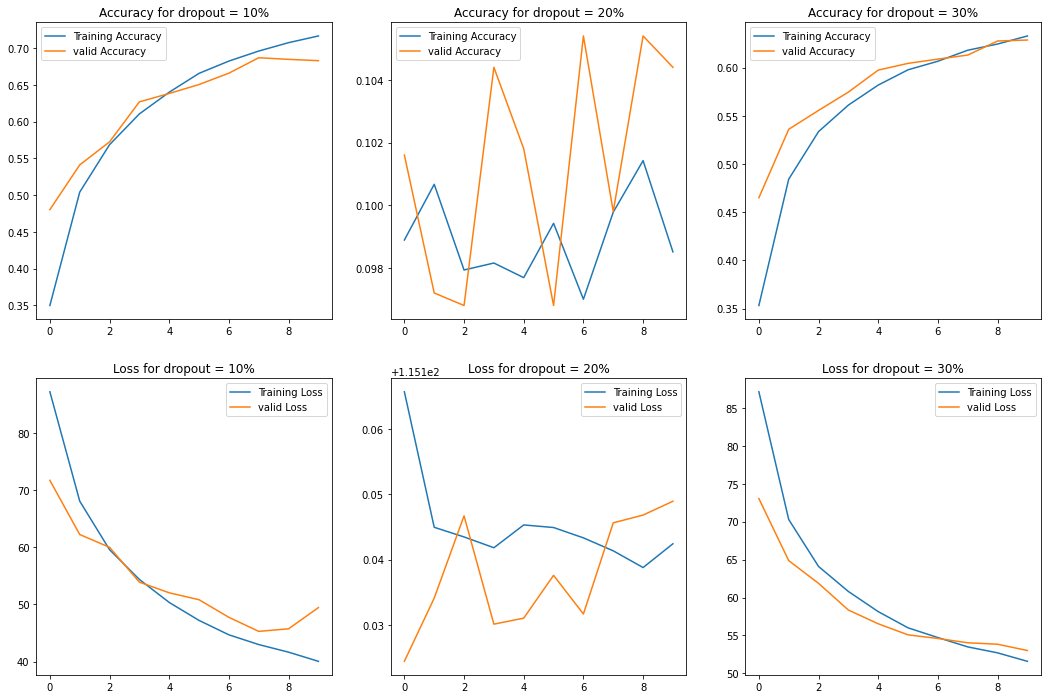

In [ ]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(2, 3, 1)
ax.plot(train_accdo10, label="Training Accuracy")
ax.plot(val_accdo10, label="valid Accuracy")
ax.set_title("Accuracy for dropout = 10%")
ax.legend()
ax = fig.add_subplot(2, 3, 4)
ax.plot(train_lossdo10, label="Training Loss")
ax.plot(val_lossdo10, label="valid Loss")
ax.set_title("Loss for dropout = 10%")
ax.legend()

ax = fig.add_subplot(2, 3, 2)
ax.plot(train_accdo20, label="Training Accuracy")
ax.plot(val_accdo20, label="valid Accuracy")
ax.set_title("Accuracy for dropout = 20%")
ax.legend()
ax = fig.add_subplot(2, 3, 5)
ax.plot(train_lossdo20, label="Training Loss")
ax.plot(val_lossdo20, label="valid Loss")
ax.set_title("Loss for dropout = 20%")
ax.legend()

ax = fig.add_subplot(2, 3, 3)
ax.plot(train_accdo30, label="Training Accuracy")
ax.plot(val_accdo30, label="valid Accuracy")
ax.set_title("Accuracy for dropout = 30%")
ax.legend()
ax = fig.add_subplot(2, 3, 6)
ax.plot(train_lossdo30, label="Training Loss")
ax.plot(val_lossdo30, label="valid Loss")
ax.set_title("Loss for dropout = 30%")
ax.legend()

# Best CNN

## Libs and modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms

## Loading Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
#Set the batch size here
batch_size=50
#set the validation set size and defining data loaders
val_size = 5000
train_size = len(dataset) - val_size
trainset, valid_set = torch.utils.data.random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
classes = dataset.classes

## Network Architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv11 = nn.Conv2d(3, 8, kernel_size=3, padding=1)  #input_channel=3 , output_channel=16
        self.conv12 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)   
        self.pool = nn.MaxPool2d(2, 2)  

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu=nn.ReLU()
        #Fully connected Layers
        self.fc1 = nn.Linear(64*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout=nn.Dropout(p=0.1)
    def forward(self, x):

        x = self.dropout(self.relu(self.conv11(x)))
        x = self.pool(self.dropout(self.relu(self.conv12(x))))
        x = self.dropout(self.relu(self.conv21(x)))
        x = self.pool(self.dropout(self.relu(self.conv22(x))))
        x = self.dropout(self.relu(self.conv31(x)))
        x = self.pool(self.dropout(self.relu(self.conv32(x))))
        
        x = x.view(-1, 64*4*4)             #Flattening
        # x = nn.Flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Optimizer & Loss Function

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.002)

## Training The Model

In [6]:
epochs = 20

valid_loss_min = np.Inf

valid_losses, train_losses = [], []
train_accuracys, valid_accuracys=[],[]
for epoch in range(1, epochs+1):

  train_loss = 0
  valid_loss = 0
  train_acc = 0
  valid_acc = 0

  # Training Phase
  for images, labels in trainloader:
    optimizer.zero_grad()
    # forward pass
    output = net(images)
    # compute loss
    loss = criterion(output, labels)
    # backward pass 
    loss.backward()
    # updtate parameters
    optimizer.step()
    train_loss += loss.item()*images.size(0)
    ps1 = torch.exp(output)
    _, top_class = ps1.topk(1, dim=1)
    equals1 = (top_class.view(batch_size) == labels)
    train_acc += torch.mean(equals1.type(torch.FloatTensor))

  # Validation 
  for images, labels in valid_loader:
    # forward pass
    output = net(images)
    # compute loss
    loss = criterion(output, labels)
    valid_loss += loss.item()*images.size(0)
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    equals = (top_class.view(batch_size) == labels)
    valid_acc += torch.mean(equals.type(torch.FloatTensor))

  train_loss = train_loss/len(trainloader)
  valid_loss = valid_loss/len(valid_loader)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  train_accuracys.append(train_acc/len(trainloader))
  valid_accuracys.append(valid_acc/len(valid_loader))

  print("Validation accuracy: {:.3f}\t".format(valid_acc/len(valid_loader)),"Train accuracy: {:.3f}".format(train_acc/len(trainloader)),
        "Epoch: {}/{} \t Training loss: {:.3f} \t Validation loss: {:.3f}".format(epoch, epochs, train_loss, valid_loss)) 
  if valid_loss <= valid_loss_min:
    print("Validation loss decreased")
    torch.save(net.state_dict(), "Best_Model")
    valid_loss_min = valid_loss

Validation accuracy: 0.478	 Train accuracy: 0.366 Epoch: 1/20 	 Training loss: 84.046 	 Validation loss: 71.518
Validation loss decreased
Validation accuracy: 0.564	 Train accuracy: 0.536 Epoch: 2/20 	 Training loss: 64.146 	 Validation loss: 60.203
Validation loss decreased
Validation accuracy: 0.612	 Train accuracy: 0.605 Epoch: 3/20 	 Training loss: 55.091 	 Validation loss: 53.886
Validation loss decreased
Validation accuracy: 0.638	 Train accuracy: 0.645 Epoch: 4/20 	 Training loss: 49.893 	 Validation loss: 50.813
Validation loss decreased
Validation accuracy: 0.653	 Train accuracy: 0.668 Epoch: 5/20 	 Training loss: 46.671 	 Validation loss: 48.668
Validation loss decreased
Validation accuracy: 0.662	 Train accuracy: 0.688 Epoch: 6/20 	 Training loss: 44.110 	 Validation loss: 49.626
Validation accuracy: 0.675	 Train accuracy: 0.702 Epoch: 7/20 	 Training loss: 41.828 	 Validation loss: 47.728
Validation loss decreased
Validation accuracy: 0.682	 Train accuracy: 0.714 Epoch: 8/2

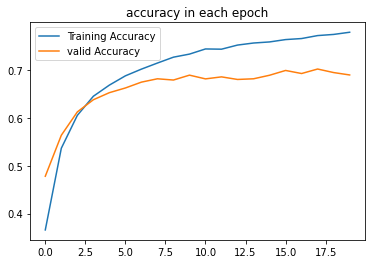

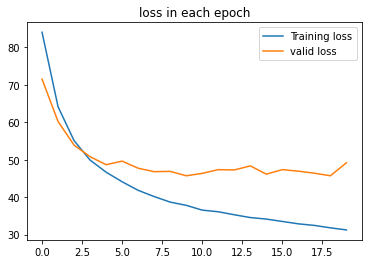

In [7]:
plt.plot(train_accuracys, label="Training Accuracy")
plt.plot(valid_accuracys, label="valid Accuracy")
plt.title('accuracy in each epoch')
plt.legend()
plt.show()
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="valid loss")
plt.title('loss in each epoch')
plt.legend()
plt.show()

## Testing the Model

In [8]:
state_dict = torch.load('/content/Best_Model')
net.load_state_dict(state_dict)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%   (%2d/%2d)' % (
        classes[i], 100 * class_correct[i] / class_total[i], class_correct[i], class_total[i]))
print('\n Overal Test Accuracy: %2d%% (%2d/%2d)' % (
      100.*np.sum(class_correct)/np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)
      ))

Accuracy of airplane : 72 %   (723/1000)
Accuracy of automobile : 82 %   (828/1000)
Accuracy of  bird : 60 %   (602/1000)
Accuracy of   cat : 61 %   (612/1000)
Accuracy of  deer : 59 %   (593/1000)
Accuracy of   dog : 55 %   (552/1000)
Accuracy of  frog : 68 %   (680/1000)
Accuracy of horse : 72 %   (728/1000)
Accuracy of  ship : 79 %   (790/1000)
Accuracy of truck : 77 %   (773/1000)

 Overal Test Accuracy: 68% (6881/10000)
